# Load Modules

In [ ]:
import os
import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern
import seaborn as sns
import cv2

# Data Preprocessing

## Downloading Dataset Files 

In [2]:
if False:
    kaggle.api.authenticate()
    path = 'Garbage_data'
    dataset = 'zlatan599/garbage-dataset-classification'

    kaggle.api.dataset_download_files(dataset, path, unzip=True)

## Handle Metadata

In [3]:
# Load Dataset Metadata
metadata_path = './Garbage_data/Garbage_Dataset_Classification/metadata.csv'
metadata_df = pd.read_csv(metadata_path)

In [4]:
def get_file_path(metadata):
    image_folder = './Garbage_data/Garbage_Dataset_Classification/images/'
    return os.path.join(image_folder, metadata['label'], metadata['filename'])

In [5]:
# Generate local filepath
metadata_df['filename'] = metadata_df.apply(get_file_path, axis=1)

display(metadata_df.head())

,filename,label
0,./Garbage_data/Garbage_Dataset_Classification/...,cardboard
1,./Garbage_data/Garbage_Dataset_Classification/...,cardboard
2,./Garbage_data/Garbage_Dataset_Classification/...,cardboard
3,./Garbage_data/Garbage_Dataset_Classification/...,cardboard
4,./Garbage_data/Garbage_Dataset_Classification/...,cardboard


## Split Dataset

In [6]:
split_seed = 13

# Stratified split to keep balance between classes
metadata_train_df, metadata_val_df = train_test_split(metadata_df,random_state=split_seed, stratify=metadata_df['label'].values)

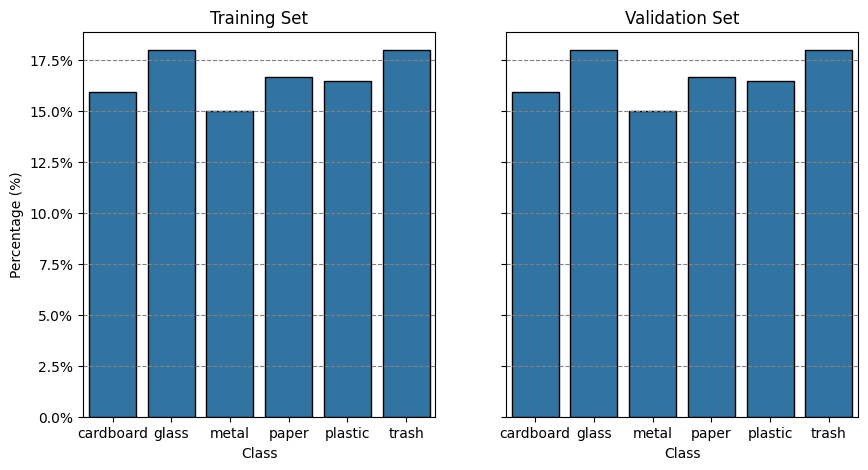

In [7]:
# Show percentage of split to ensure stratification.

train_counts = metadata_train_df['label'].value_counts(normalize=True).sort_index()
val_counts = metadata_val_df['label'].value_counts(normalize=True).sort_index()


fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)

sns.barplot(x=train_counts.index, y=train_counts.values, ax=ax[0], edgecolor = 'black')
ax[0].set_title('Training Set')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Percentage (%)')
ax[0].yaxis.set_major_formatter(PercentFormatter(1))
ax[0].grid(axis='y', color='gray', linestyle='--')

sns.barplot(x=val_counts.index, y=val_counts.values, ax=ax[1], edgecolor= 'black')
ax[1].set_title('Validation Set')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Percentage (%)')
ax[1].yaxis.set_major_formatter(PercentFormatter(1))
ax[1].grid(axis='y', color='gray', linestyle='--')




## Feature Extraction

### Resize and Grayscale

In [8]:
# Resize and convert images to grayscale

def ResizeandGray(size, image):
        # reduce image size to 32x32
        image_resize = cv2.resize(image, (size,size))
        # convert image to grayscale
        image_gray = cv2.cvtColor(image_resize, cv2.COLOR_BGR2GRAY)
        return image_gray



# apply gausian blur to image
def BlurImage(image):
        blur_image = cv2.GaussianBlur(image, (5,5), 0)
        return blur_image

### Assemble Pixelated Dataset

In [ ]:
# Full pixel RGB feature set, 65536 features

def FormDataset(metadata_df):

    image_list = []

    for filename in metadata_df['filename'].values:
        image = cv2.imread(filename)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_list.append(image_rgb.flatten())
        

    df = pd.DataFrame(np.array(image_list))
    df['label'] = metadata_df['label'].values
    
    return df


### Assemble Histogram of Oriented Gradients Feature Dataset (Shape Feature)

In [ ]:
# Assembles Grayscale HOG Dataset
def FormHogDataset(metadata_df):
    
    HOG_vector_list = []
    
    # Define HOG parameters
    win_size = (32, 32)
    block_size = (8, 8) 
    block_stride = (4, 4)  
    cell_size = (4, 4)
    nbins = 9

    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)

    for filename in metadata_df['filename'].values:
        image = cv2.imread(filename)
        modified_image = BlurImage(ResizeandGray(32,image))
        
        # compute HOG features
        HOG_features = hog.compute(modified_image)
        HOG_vector_list.append(HOG_features.flatten())
    
    df = pd.DataFrame(np.array(HOG_vector_list))

    df['label'] = metadata_df['label'].values


    return df

### Extract Local Binary Pattern (Texture Feature)

In [11]:
def FormLBPDataset(metadata_df):

    # term used for normalization to prevent division by 0
    e = 1e-7
    # neighborhood size
    p = 16
    # radius of neighborhood
    r = 1
    # lbp method
    method = 'uniform'

    histograms = []

    for filename in metadata_df['filename'].values:
        image = cv2.imread(filename)
        modified_image = BlurImage(ResizeandGray(32, image))
        
        # calculate and form histogram for lbp of each image
        lbp_image = local_binary_pattern(modified_image,p,r,method=method)
        hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, p+3), range=(0,p+2))
        
        # normalize the histogram
        hist = hist.astype('float')
        hist /= (hist.sum() + e)
        
        
        histograms.append(hist)
        
    
    df = pd.DataFrame(np.array(histograms))
    df['label'] = metadata_df['label'].values
        
    return df 

## Form Modified Feature dataset for saving

In [12]:
HOG_train_df = FormHogDataset(metadata_train_df)
HOG_val_df = FormHogDataset(metadata_val_df)
LBP_train_df = FormLBPDataset(metadata_train_df)
LBP_val_df = FormLBPDataset(metadata_val_df)

In [13]:
# combine all features into a single dataframe
Combined_Feature_train_df = pd.concat([HOG_train_df.drop(columns='label'), LBP_train_df.drop(columns='label')], axis =1)
Combined_Feature_train_df.columns = range(0, Combined_Feature_train_df.shape[1])
Combined_Feature_train_df['label'] = HOG_train_df['label'].values


Combined_Feature_val_df = pd.concat([HOG_val_df.drop(columns='label'), LBP_val_df.drop(columns='label')], axis=1)
Combined_Feature_val_df.columns = range(0, Combined_Feature_val_df.shape[1])
Combined_Feature_val_df['label'] = HOG_val_df['label'].values

### Save and Load Feature Specific Datasets

In [14]:
# save dataframes as feather files
if True:
    HOG_train_df.to_feather('Garbage_data/HOG_train.feather')
    HOG_val_df.to_feather('Garbage_data/HOG_val.feather')
    LBP_train_df.to_feather('Garbage_data/LBP_train.feather')
    LBP_val_df.to_feather('Garbage_data/LBP_val.feather')
    Combined_Feature_train_df.to_feather('Garbage_data/Combined_Feature_train.feather')
    Combined_Feature_val_df.to_feather('Garbage_data/Combined_Feature_val.feather')

c:\Users\mfecc\anaconda3\Lib\site-packages\pyarrow\feather.py:156: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = Table.from_pandas(df, preserve_index=preserve_index)
